# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
from bootstrap import btset_cd, generateplots, btShInh


# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
#data.dt = 0.05
#data.NMDA = False


# Definition of the model.

#NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)
data.model = model.__dict__
lb.h.dt = data.model['dt']

# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="DendA2",locus=3,L=240.0,D=0.5,ilocus=1)

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendA2(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Bootstrapping spines



In [2]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']*2
sis['Rneck'] = sis['Rneck']*2
sps['Rneck'] = sps['Rneck']*2
#generateplots(dis,corplot=True)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])

Area Volume Ah Vh
1.0799491896062636 0.1433038731202827 0.9611135861557448 0.11079114472127966


In [3]:
#nsp = 1000
#figure()
iPSDsh = btShInh(size=nsp)
#h = hist(iPSDsh,31)
#xlabel("iPSD shaft ($\mu m^2$)",fontsize=14)


In [4]:

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*0.4
gtrA = rhAMPAR*11e-6*0.6
gtrN = rhNMDAR*30e-6*3.075787


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [5]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.1
tau2 = 1.8
AMPA.tau1 = tau1
AMPA.tau2 = tau2

gmax = gtrG*sps['A1'].mean()
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 5.0
NMDA.tau2 = 17.0


### Inhibitory synapse

In [6]:
gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  


# Recordings

In [7]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [8]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [9]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [10]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [11]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[38]

## Small tuning parameters for dendrite?

In [12]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),178)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.7
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.7
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
178.0 0.699999988079071 19.098593171027442
1.0 0.7 365.99141972519647
The resistance of neck and the dendritic impedance are 84.88 and 368 MΩ (resp.)


In [13]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]
dendN.L = 1

In [14]:
dendsh.diam = 0.87
dendc.diam = 0.87
dendN.diam = 0.87       

In [ ]:
mean(sps['Ah'])

In [19]:
rhosp = 1.3
dendareaperL = rhosp*mean(sps['Ah'])+(pi*mean(sps['meanDneck'])/1e3)
factor = dendareaperL/(pi*dendc.diam)
print(factor)
dendN.cm = 3.0
dendc.cm = 3.0

dendN.g_pas = 3.0/model.RM
dendc.g_pas = 3.0/model.RM

3.1095307834835184


In [20]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


In [21]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

In [22]:
diam0 = 0.15
#Rneck0 = Rneck/1e6
#Cm0 = model.CM


In [23]:
Rneck0 = neck.Ra*sps['Lneck']/(diam0)**2*0.04/pi
#print(Rneck0,data[i,3])
#diams = diam0*sqrt(Rneck0/sps['Rneck'])
#hist(diams, 51,density = True)
#hist(sps['minDneck']/1e3,51,alpha=0.7,density = True)
#hist(sps['meanDneck']/1e3,51,alpha=0.7,density = True)

In [24]:
def simulateSet(model,spn,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = None,VDCC = array([0.,0,0,0]), dendrec = True):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    sp.Ra = 500
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"], spn["meanDneck"]/1e3))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        # neck.diam = data[i,9]
        # Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
        # neck.Ra = data[i,3]*(neck.diam)**2*pi/0.04/neck.L
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendc.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendc(f)._ref_v)
            else:
                vDendEL[il].record(dendc(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendc.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendN(f)._ref_v)
            else:
                vDendEL2[il].record(dendN(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
        

                    
        #print(data[i,:])
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,max(vDendRec[3])-EL,max(vrec)-EL,max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],spvol,max(current)]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,array(trec))

In [25]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [26]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [27]:
from PS_tools import *

In [28]:
from bootstrap import dataset,datasetfile
with open(datasetfile,"rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
spdata['A2'][isnan(spdata['A2'])] = 0.0
spdata['Rneck'] = 2*spdata['Rneck']

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)

for key in keys:
    sel = sel*isfinite(spdata[key])
    
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    #print(key,':',isfinite(spdata[key]).sum())

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [29]:
gtrA0 = gtrA

In [30]:
factor = 7
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = 50

gtrA = gtrA0*60.5/49

for sec in lb.h.allsec():
    sec.Ra = 150

In [31]:
((model.comp['dendB1'].cm*1e-6)/(model.comp['dendB1'].g_pas)/1e-3)


7.0

In [32]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
#with open("../SpineModel/All_baseline_datasetx2.pickle","wb") as f:
#    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,spdata],f) 
 

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in sqrt


Spines <uEPSC> = 111.31, (med,cf int 0.68) = (83.30,34.21,198.39)
DiS <uEPSC> = 169.09, (med,cf int 0.68) = (164.52,82.45,270.29)
SiS <uEPSP> = 2.16, (med,cf int 0.68) = (1.59,0.69,3.78)
CV and conductance 0.7635181725786475 2.334051387937347


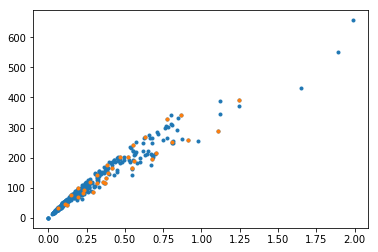

In [33]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[~sel,3],0.68)
print('SiS <uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

In [30]:
mes.std(axis=0)/mes.mean(axis=0)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 0.91217706,  0.64073103,  0.75141724,  0.77403054,  0.86242329,
               nan, -0.76063237,  0.98443153,  0.75187976])

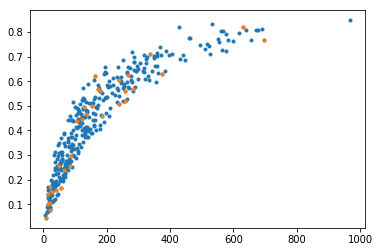

In [31]:
plot(spdata['Rneck'],(mes[:,1]-mes[:,2])/mes[:,1],'.')
sel = spdata['nPSD']==2.0
plot(spdata['Rneck'][sel],(mes[sel,1]-mes[sel,2])/mes[sel,1],'.')

Spines <uEPSC> = 58.67, (med,cf int 0.68) = (45.15,19.29,104.12)
DiS <uEPSC> = 86.86, (med,cf int 0.68) = (85.51,42.50,132.93)
SiS <uEPSP> = 1.89, (med,cf int 0.68) = (1.37,0.59,3.24)
CV and conductance 0.7740305355451184 1.1799259140419345


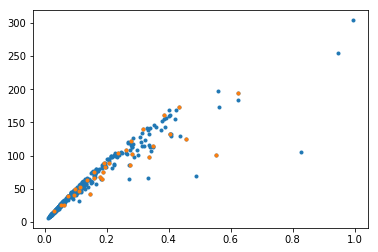

In [32]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[~sel,3],0.68)
print('SiS <uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

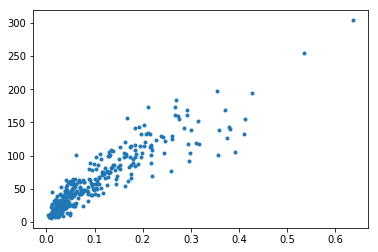

In [33]:
plot(spdata['Vh'],-mes[:,-3]*1000,'.')

In [34]:
AMPA2 = lb.h.Exp2Syn(1,sec = model.soma)
tau1  = 0.01
tau2 = 100000
AMPA2.tau1 = tau1
AMPA2.tau2 = tau2

stimE2=lb.h.NetStim();stimE2.number = 1; 
NC2 = lb.h.NetCon(stimE2,AMPA2,0,0,gmax)

model.AMPAlist.append(AMPA2)
model.ncAMPAlist.append(NC2)
NC2.delay = 10
iRec.append(lb.h.Vector())
currentAMPA2 = iRec[-1]
currentAMPA2.record(AMPA2._ref_i)


Vector[39]

In [35]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in sqrt


In [47]:
def simInputRes(model,toffset = 50,t_stop = 100, EL = -65):
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
         
    NC.weight[0]  = gtrA*0
    NCN.weight[0] = gtrN*0
    NCG.weight[0] = gtrG*0
    NC.delay = toffset
    NCN.delay = toffset
    NCG.delay = toffset  


    
    posD = 50.0

    dendc.L = posD-dshL/2
    dendN.L = dendsizeL-posD-dshL/2

    # A = pi*D**2
    #sp.L = data[i,5]
    #sp.diam = data[i,6]
    #sp.cm = data[i,8]
    #sp.g_pas = data[i,8]/model.RM
    #spvol = sp(0.5).volume()
    #spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2

    CaTcond = 1e-3# pS
    sp.pbar_caL13PS =0.0*CaTcond#/spineArea
    sp.pbar_caLPS = 0.0*CaTcond#/spineArea
    sp.pbar_canPS = 0.0*CaTcond#/spineArea
    sp.pcaqbar_caqPS = 0.0*CaTcond#/spineArea

    for il in range(10):
        f = 1-7.5*il/dendc.L
        #f = 0.5
        if f>=0:
            vDendEL[il].record(dendc(f)._ref_v)
        else:
            vDendEL[il].record(dendc(0.0)._ref_v)

    for il in range(10):
        f = 7.5*il/dendc.L
        #f = 0.5
        if f<=1:
            vDendEL2[il].record(dendN(f)._ref_v)
        else:
            vDendEL2[il].record(dendN(1.0)._ref_v)
    
    nx = 51
    mes = zeros((nx,3))
    for i,dx in enumerate(linspace(0.0,0.2,nx)):
        #print(i,dx,gtrA*dx)
        NC2.weight[0] = gtrA*dx
        NC2.delay = toffset


        lb.h.finitialize(model.E_PAS)

        lb.neuron.run(t_stop)



        mes[i,:] = (gtrA*dx,max(vrec)-EL,max(abs(array(currentAMPA2))))

    return(mes,vrec,array(currentAMPA2))

In [48]:
mes,vrec,icur = simInputRes(model,toffset = 50,t_stop = 200, EL = -70)

0 0.0 0.0
1 0.004 3.2595918367346934e-05
2 0.008 6.519183673469387e-05
3 0.012 9.77877551020408e-05
4 0.016 0.00013038367346938774
5 0.02 0.00016297959183673468
6 0.024 0.0001955755102040816
7 0.028 0.00022817142857142853
8 0.032 0.00026076734693877547
9 0.036000000000000004 0.00029336326530612244
10 0.04 0.00032595918367346935
11 0.044 0.0003585551020408162
12 0.048 0.0003911510204081632
13 0.052000000000000005 0.00042374693877551015
14 0.056 0.00045634285714285706
15 0.06 0.000488938775510204
16 0.064 0.0005215346938775509
17 0.068 0.0005541306122448979
18 0.07200000000000001 0.0005867265306122449
19 0.076 0.0006193224489795917
20 0.08 0.0006519183673469387
21 0.084 0.0006845142857142857
22 0.088 0.0007171102040816324
23 0.092 0.0007497061224489794
24 0.096 0.0007823020408163264
25 0.1 0.0008148979591836733
26 0.10400000000000001 0.0008474938775510203
27 0.108 0.0008800897959183672
28 0.112 0.0009126857142857141
29 0.116 0.0009452816326530611
30 0.12 0.000977877551020408
31 0.124 0.0

155.07117233728655


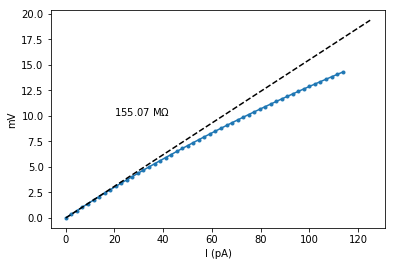

In [54]:
plot(mes[:,2]*1e3,mes[:,1],'.-')
xs = linspace(0,0.125)
plot(xs*1e3,xs*mes[3,1]/mes[3,2],'k--')
annotate('%.2f M$\Omega$' % (mes[3,1]*1e-3/mes[3,2]/1e-9/1e6),xy = (20,10))
xlabel('I (pA)')
ylabel('mV')
print(mes[3,1]*1e-3/mes[3,2]/1e-9/1e6)